<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/1d_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal:
- implement 1d classification a la Nelson, 2019
- learn additional noise parameters from data (additive gaussian nose, mean and var of shifts)

# TODO:
- speed up with convolution implementation (verify matched explicit implementation)

# Generate fake data

In [0]:
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns



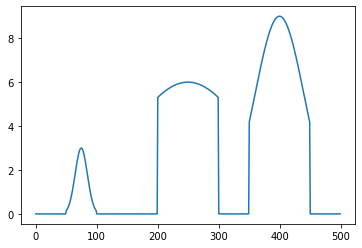

In [145]:
M = 500
N=50
sigma = 6
A = np.zeros(M)
span=50
std=10
A[1*span:2*span] = 3*scipy.signal.gaussian(1*span,1*std)
A[4*span:6*span] = 6*scipy.signal.gaussian(2*span,10*std,)
A[7*span:9*span] = 9*scipy.signal.gaussian(2*span,4*std)
pd.Series(A).plot()

In [0]:
def shift_zeropad(x,shift):
  if np.isclose(shift, 0): return(x)
  
  x = np.roll(x,shift)
  if shift > 0:
    x[:shift] = 0
  else:
    x[shift:] = 0
  
  return(x)

In [0]:
def make_fake(A,sigma,sigma_shift,mean_shift=0,return_shift=False):
  shift = np.ceil(np.random.normal(size=1,loc=mean_shift,scale=sigma_shift)).astype(int)[0]
  x=shift_zeropad(A,shift)
  x += sigma*np.random.normal(size=A.shape)
  if return_shift: return(x,shift)
  else: return(x)


array([ -25,  -59,   -3,   23,   13,  -14,  -21, -126,  -52,  -27, -119,
        -35,  241,  -53,   61, -159,  -98,  231,  -75,  222,  -43,  -83,
         39,    0,   52,    4,  125,  -55,  -21,   13,   97,   94, -228,
         21,   90,  -47,  146,    6,  -20, -107,   -9,   43,   63,    4,
        125, -140,  108,    8,  148,  -18], dtype=int32)

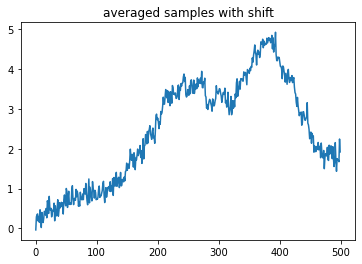

In [146]:
sigma_shift=100
mean_shift=0
X = np.zeros((N,M))
true_shifts = np.zeros(N,dtype=np.int32)
sigma=1
for i in range(N):
  X[i,:], true_shifts[i] = make_fake(A.copy(),sigma,sigma_shift=sigma_shift,mean_shift=mean_shift,return_shift=True)

pd.Series(X.mean(0)).plot(title='averaged samples with shift') 
true_shifts

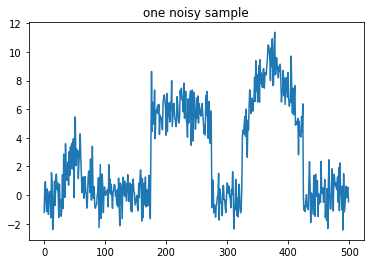

In [147]:
pd.Series(X[0]).plot(title='one noisy sample')

# Build equations for algorithm
- table of shifted A
- table of norms of shifted A
- table of pdf of shifts
- loop over samples
  - corr shift A,x; for all x in X
  - compute gi
  - sum over u to get norm factor U
  - accumulate log likelihood
- reverse shift
- sum over i
- update A

## table of shifted A

In [0]:
A_prev = X.mean(0)
shifts = np.arange(-M,M+1, dtype=np.int32)


In [0]:
A_shifted = np.zeros((shifts.shape[0],M))
for shift_idx,shift in enumerate(shifts):
  A_shifted[shift_idx,:] = shift_zeropad(A_prev,shift)

##table of norms of shifted A

In [0]:

A_shifted_norm = np.linalg.norm(A_shifted,axis=1)

## table of pdf of shifts

In [0]:
shift_pdf = np.zeros(shifts.shape)
for idx,s in enumerate(shifts): 
  shift_pdf[idx] = scipy.stats.norm.pdf(s)#np.exp(-s**2/2)*(2*np.pi)**-0.5


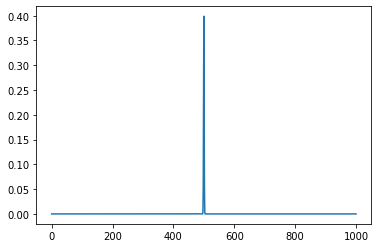

In [122]:
pd.Series(shift_pdf).plot()

## corr shift A,x; for all x in X exponentiate for gi

In [0]:
x = X[0]
corr_A_x = np.zeros(A_shifted.shape[0])
for idx,a_shifted in enumerate(A_shifted):
  corr_A_x[idx] = np.multiply(a_shifted,x).sum()
corr_A_x *= sigma**-2

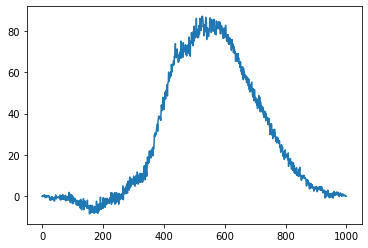

In [127]:
pd.Series(corr_A_x).plot()

In [0]:
A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
corr_A_x_ = sigma**-2*corr_A_x
Ki = max(corr_A_x_.max(),A_shifted_norm_.max()) # for numerical stability?

gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf

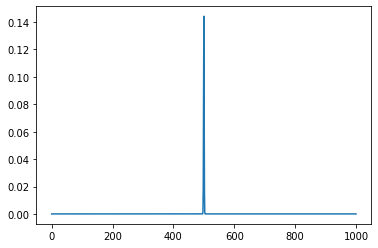

In [129]:
pd.Series(gi).plot()

## sum over u to get norm factor U

In [130]:
Ui = gi.sum()**-1
Ui

3.0320587288219443

## accumulate loglikelihood

In [131]:
-np.log(Ui) # sigma factor missing, same for all i

-1.1092418372567654

## reverse shift

In [0]:
x_shifted = np.zeros((shifts.shape[0],X.shape[1]))
for shift_idx,shift in enumerate(shifts):
  x_shifted[shift_idx,:] = shift_zeropad(x,shift) # have to reverse shift?

In [133]:
x_shifted.shape, gi.shape

((1001, 500), (1001,))

In [0]:
a=0
conv_i = np.multiply(gi,x_shifted[:,a]).sum() 

In [348]:
#scipy.signal.convolve(range(10),range(10),mode='same')

array([ 10,  20,  35,  56,  84, 120, 165, 200, 224, 236])

In [349]:
#scipy.ndimage.convolve(range(10),range(10),mode='constant')

array([ 20,  35,  56,  84, 120, 165, 200, 224, 236, 235])

In [350]:
#scipy.ndimage.convolve1d(range(10),range(10),mode='constant')

array([ 20,  35,  56,  84, 120, 165, 200, 224, 236, 235])

In [381]:
Ui*conv_i

0.14151956676158675

# sum over i to get A next
- per pixel
- have to put together steps from before

In [0]:
# initialize

A_prev = X.mean(0)
shifts = np.arange(-M,M+1, dtype=np.int32)
A_next = A_prev.copy()

#idx_rand = np.arange(X.shape[0],dtype=np.int32)

i = 0, ll = -15945.27, A_next max = 11.22
i = 5, ll = -92219.64, A_next max = 58.49
i = 10, ll = -169498.21, A_next max = 104.99
i = 15, ll = -236463.06, A_next max = 141.61
i = 20, ll = -294105.37, A_next max = 168.38
i = 25, ll = -371325.35, A_next max = 214.59
i = 30, ll = -438178.02, A_next max = 250.32
i = 35, ll = -507976.07, A_next max = 295.02
i = 40, ll = -575338.14, A_next max = 332.22
i = 45, ll = -645442.12, A_next max = 368.20
i = 0, ll = -14624.92, A_next max = 11.38
i = 5, ll = -84809.83, A_next max = 57.01
i = 10, ll = -155760.56, A_next max = 106.76
i = 15, ll = -217427.39, A_next max = 141.25
i = 20, ll = -270484.42, A_next max = 170.19
i = 25, ll = -341675.67, A_next max = 215.86
i = 30, ll = -403079.34, A_next max = 255.14
i = 35, ll = -467430.80, A_next max = 301.45
i = 40, ll = -529481.87, A_next max = 334.80
i = 45, ll = -594136.29, A_next max = 371.65
i = 0, ll = -14597.19, A_next max = 11.38
i = 5, ll = -84647.72, A_next max = 58.73
i = 10, ll = -155433.69, A_n

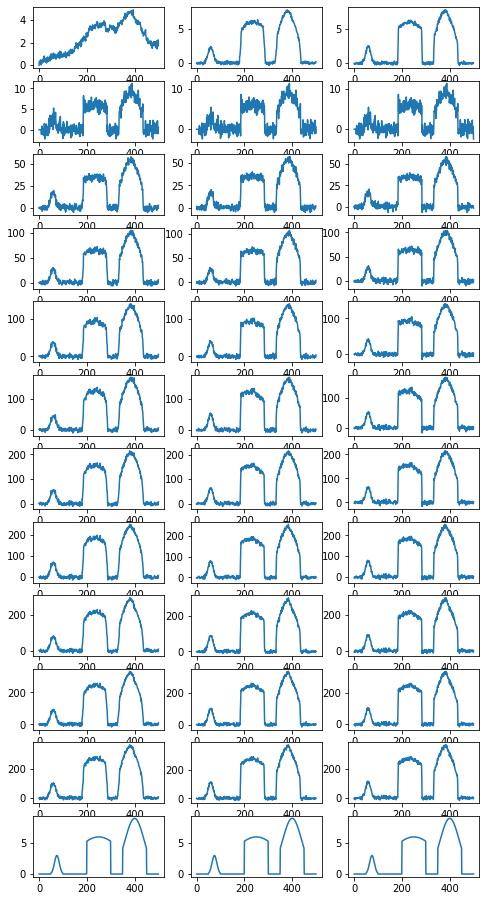

In [149]:
n_A_updates=3
fig, axes = plt.subplots(12, n_A_updates,figsize=(8,16))


for c in range(n_A_updates):
  

  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  pd.Series(A_prev).plot(ax=axes[0,c])

  # shift A
  A_shifted = np.zeros((shifts.shape[0],M))
  for shift_idx,shift in enumerate(shifts):
    A_shifted[shift_idx,:] = shift_zeropad(A_prev,shift)

  # norm A
  A_shifted_norm = np.linalg.norm(A_shifted,axis=1)**2

  # pdf shifts
  shift_pdf = np.zeros(shifts.shape)
  for idx,s in enumerate(shifts): 
    shift_pdf[idx] = np.exp(-s**2/(2*sigma_shift**2))*(2*np.pi)**-0.5#scipy.stats.norm.pdf(s,)#

  r=0
  best_shifts = np.zeros_like(true_shifts)

  idx_rand = np.arange(X.shape[0],dtype=np.int32)

  #np.random.shuffle(idx_rand)

  for i,x in enumerate(X):

    # corr
    corr_A_x = np.zeros(A_shifted.shape[0])
    for idx,a_shifted in enumerate(A_shifted):
      corr_A_x[idx] = np.multiply(a_shifted,x).sum()
    best_shifts[i] = np.argmax(corr_A_x) - (N + 1)
    
    # gi
    A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
    corr_A_x_ = sigma**-2*corr_A_x
    Ki = np.max(corr_A_x_ + A_shifted_norm_) # for numerical stability?

    gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0

    # rev shift
    x_shifted = np.zeros((shifts.shape[0],X.shape[1]))
    for shift_idx,shift in enumerate(shifts):
      x_shifted[shift_idx,:] = shift_zeropad(x,-shift) # have to reverse shift?

    conv = np.zeros(A_prev.shape[0])
    for A_idx in range(A_prev.shape[0]):
    # sum over shifts
      conv[A_idx] = np.multiply(gi,x_shifted[:,A_idx]).sum()
      A_next[A_idx] += Ui*conv[A_idx] # perhaps accumulate and sum later... maybe better numerical stability
    
    if i % int(X.shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,A_next.max()))
      pd.Series(A_next).plot(ax=axes[r+1,c])
      r+=1

  A_next *= N**-1
  pd.Series(A).plot(ax=axes[r+1,c])

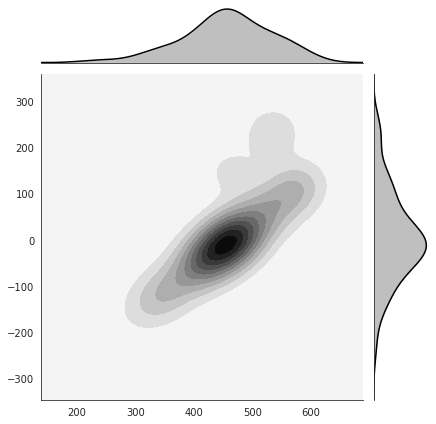

In [150]:
with sns.axes_style("white"):
    sns.jointplot(x=best_shifts, y=true_shifts, kind="kde", color="k");

# jit

In [0]:
n_A_updates=3
fig, axes = plt.subplots(12, n_A_updates,figsize=(8,16))


for c in range(n_A_updates):
  

  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  pd.Series(A_prev).plot(ax=axes[0,c])

  # shift A
  A_shifted = np.zeros((shifts.shape[0],M))
  for shift_idx,shift in enumerate(shifts):
    A_shifted[shift_idx,:] = shift_zeropad(A_prev,shift)

  # norm A
  A_shifted_norm = np.linalg.norm(A_shifted,axis=1)**2

  # pdf shifts
  shift_pdf = np.zeros(shifts.shape)
  for idx,s in enumerate(shifts): 
    shift_pdf[idx] = np.exp(-s**2/(2*sigma_shift**2))*(2*np.pi)**-0.5#scipy.stats.norm.pdf(s,)#

  r=0
  best_shifts = np.zeros_like(true_shifts)

  idx_rand = np.arange(X.shape[0],dtype=np.int32)

  #np.random.shuffle(idx_rand)

  for i,x in enumerate(X):

    # corr
    corr_A_x = compute_corr(A_shifted,x)
    best_shifts[i] = np.argmax(corr_A_x) - (N + 1)
    
    # gi
    A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
    corr_A_x_ = sigma**-2*corr_A_x
    Ki = np.max(corr_A_x_ + A_shifted_norm_) # for numerical stability?

    gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0

    # rev shift
    x_shifted = np.zeros((shifts.shape[0],X.shape[1]))
    for shift_idx,shift in enumerate(shifts):
      x_shifted[shift_idx,:] = shift_zeropad(x,-shift) # have to reverse shift?

    conv = np.zeros(A_prev.shape[0])
    for A_idx in range(A_prev.shape[0]):
    # sum over shifts
      conv[A_idx] = np.multiply(gi,x_shifted[:,A_idx]).sum()
      A_next[A_idx] += Ui*conv[A_idx] # perhaps accumulate and sum later... maybe better numerical stability
    
    if i % int(X.shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,A_next.max()))
      pd.Series(A_next).plot(ax=axes[r+1,c])
      r+=1

  A_next *= N**-1
  pd.Series(A).plot(ax=axes[r+1,c])

In [57]:
A_shifted.shape, a_shifted.shape

((1001, 500), (500,))

In [0]:
@nb.jit
def compute_corr(A_shifted,x):
  corr_A_x = np.zeros(A_shifted.shape[0])
  for idx in range(A_shifted.shape[0]):
    corr_A_x[idx] = np.multiply(A_shifted[idx],x).sum()
  return(corr_A_x)



In [71]:
%timeit compute_corr(A_shifted,x)

The slowest run took 269.20 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.08 ms per loop


In [69]:
%timeit compute_corr(A_shifted,x)

100 loops, best of 3: 3.85 ms per loop


# update noise
- we can estimate the sigma noise from the data. See Eq 12.31 in Nelson

## helper functions

In [13]:
A_shifted.shape, x.shape

((1001, 500), (500,))

In [0]:
errors = np.linalg.norm(A_shifted - x,axis=1)**2 # difference between image and template. broadcast diff


In [33]:
gi.shape, errors.shape, (A_shifted - x).shape

((1001,), (1001,), (1001, 500))

In [39]:
e = (gi*errors).sum() # integral
e

19218.556201718817

In [37]:
sigma_i = e / gi.sum()
sigma_i

21206.29298105381

## algorithm, with sigma estimation from data
- the estimaged sigma is very close to the true sigma
- how to get initial estimage of sigma? split data into two halves?

|M (number examples)|iteration (of template)|true sigma|estimated sigma|
|-|-|-|-|
|250|0|6|6 (initial guess)|
|250|1|6|6.50|
|250|2|6|6.52|
|250|3|6|6.41|
|-|-|-|-|
|250|0|6|3 (initial guess)|
|250|1|6|6.49|
|250|2|6|6.50|
|250|3|6|6.40|
|-|-|-|-|
|250|0|6|12 (initial guess)|
|250|1|6|6.54|
|250|2|6|6.6|
|250|3|6|6.42|





In [0]:
A_prev = X.mean(0)
shifts = np.arange(-M,M+1, dtype=np.int32)
A_next = A_prev.copy()
sigma=1


i = 0, ll = -15945.27, A_next max = 11.22
i = 5, ll = -92219.64, A_next max = 58.49
i = 10, ll = -169498.21, A_next max = 104.99
i = 15, ll = -236463.06, A_next max = 141.61
i = 20, ll = -294105.37, A_next max = 168.38
i = 25, ll = -371325.35, A_next max = 214.59
i = 30, ll = -438178.02, A_next max = 250.32
i = 35, ll = -507976.07, A_next max = 295.02
i = 40, ll = -575338.14, A_next max = 332.22
i = 45, ll = -645442.12, A_next max = 368.20
old sigma  1.00
new sigma  2.42
i = 0, ll = -2493.40, A_next max = 10.60
i = 5, ll = -14457.65, A_next max = 56.89
i = 10, ll = -26553.33, A_next max = 103.02
i = 15, ll = -37068.28, A_next max = 137.83
i = 20, ll = -46117.97, A_next max = 167.06
i = 25, ll = -58254.26, A_next max = 212.37
i = 30, ll = -68722.89, A_next max = 250.19
i = 35, ll = -79695.51, A_next max = 296.69
i = 40, ll = -90275.26, A_next max = 330.79
i = 45, ll = -101298.91, A_next max = 366.59
old sigma  2.42
new sigma  1.20
i = 0, ll = -10058.47, A_next max = 11.37
i = 5, ll = -5

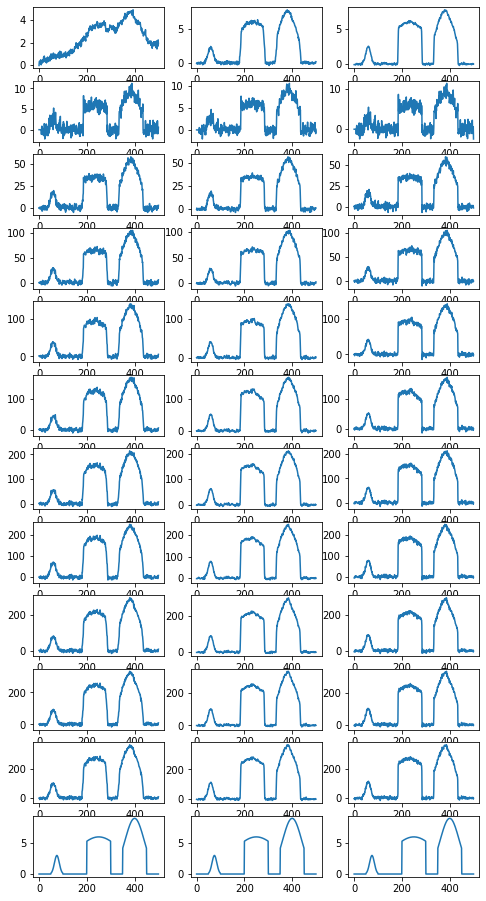

In [152]:
n_A_updates=3
fig, axes = plt.subplots(12, n_A_updates,figsize=(8,16))


for c in range(n_A_updates):
  

  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  pd.Series(A_prev).plot(ax=axes[0,c])

  # shift A
  A_shifted = np.zeros((shifts.shape[0],M))
  for shift_idx,shift in enumerate(shifts):
    A_shifted[shift_idx,:] = shift_zeropad(A_prev,shift)

  # norm A
  A_shifted_norm = np.linalg.norm(A_shifted,axis=1)**2

  # pdf shifts
  shift_pdf = np.zeros(shifts.shape)
  for idx,s in enumerate(shifts): 
    shift_pdf[idx] = np.exp(-s**2/(2*sigma_shift**2))*(2*np.pi)**-0.5#scipy.stats.norm.pdf(s,)#

  r=0
  best_shifts = np.zeros_like(true_shifts)

  idx_rand = np.arange(X.shape[0],dtype=np.int32)

  #np.random.shuffle(idx_rand)

  sigma2s = np.zeros(N)
  for i,x in enumerate(X):

    # corr
    corr_A_x = compute_corr(A_shifted,x)
    best_shifts[i] = np.argmax(corr_A_x) - (N + 1)
    
    # gi
    A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
    corr_A_x_ = sigma**-2*corr_A_x
    Ki = np.max(corr_A_x_ + A_shifted_norm_) # for numerical stability?

    gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0

    # rev shift
    x_shifted = np.zeros((shifts.shape[0],X.shape[1]))
    for shift_idx,shift in enumerate(shifts):
      x_shifted[shift_idx,:] = shift_zeropad(x,-shift) # have to reverse shift?

    conv = np.zeros(A_prev.shape[0])
    for A_idx in range(A_prev.shape[0]):
    # sum over shifts
      conv[A_idx] = np.multiply(gi,x_shifted[:,A_idx]).sum()
      A_next[A_idx] += Ui*conv[A_idx] # perhaps accumulate and sum later... maybe better numerical stability
    
    if i % int(X.shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,A_next.max()))
      pd.Series(A_next).plot(ax=axes[r+1,c])
      r+=1

    # sigma estimation
    errors = np.linalg.norm(A_shifted - x,axis=1)**2 # difference between image and template. broadcast diff
    sigma2_i = (gi*errors).sum()
    sigma2_i /= gi.sum()
    sigma2s[i] = sigma2_i
  print('old sigma % .2f' % sigma)
  sigma2 = sigma2s.sum()
  sigma2 /= N*M
  sigma = np.sqrt(sigma2)
  print('new sigma % .2f' % sigma)

  A_next *= N**-1
  pd.Series(A).plot(ax=axes[r+1,c])

# estimating spread of shift, $\sigma_q$
- the spread of the shifts affects the pdfs, and so how much we weight the contributions of other alignments
- I think Nelson leaves out an important normalization factor from 12.9 to 12.11, which greatly effect the analytical equation for $\sigma_q^{next}$
- If Eq 12.11 should include a factor of $(2 \pi \sigma_q)$, then these results follow
- By symmetry of the derivative of $\gamma_i$ wrt $\sigma$ and $\sigma_q$ (if $M=1$), the result of 12.31 follows, exchanging
  * $\sigma$ and $\sigma_q$; these both can be taken out of the integral and the sum over i
  * $\sum A - X$ and $q^2$; these both can't be taken out of the integral
- Therefore, $(\sigma_q^{2})^{\text{next}} = ((M=1)N)^{-1} \sum_i \frac{\int dq \ \gamma_i q^2}{\int dq^{'} \ \gamma_i^{'}}$
- Note: $(\sigma_q)$ keeps shrinking each template iteration if we have a factor of $(2 \pi \sigma_q)^{M/2}$ in Eq 12.11


## helper functions

In [64]:
shifts.shape,gi.shape


23221.38734705308

In [69]:
(gi*shifts**2).sum()# upstairs

23221.38734705308

In [65]:
gi.sum() # downstairs

1.9988594156559816

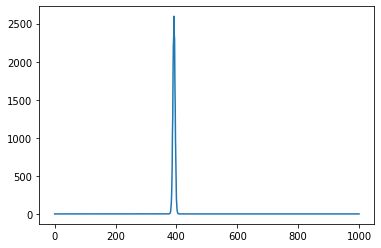

In [67]:
pd.Series(gi*shifts**2).plot() # makes intuitive sense... weights the shifts by gamma i

In [73]:
sigma2_shift = (gi*shifts**2).sum()/gi.sum()/N # real one is 100
sigma2_shift

23.234637879155034

In [71]:
sigma_shift, np.sqrt(sigma2_shift)

100

## updated algorithm
- now estimate template, $\sigma$ and $\sigma_{q}$ from data



|M (number examples)|true sigma|iteration (of template)|true sigma shift|estimated sigma shift|
|-|-|-|-|-|
|50|1|1|0|100|100 (initial guess)|
|||1|100|97.50|
|||2|100|98.95|
|||3|100|99.20|


   

In [0]:
A_prev = X.mean(0)
shifts = np.arange(-M,M+1, dtype=np.int32)
A_next = A_prev.copy()
sigma=1
sigma_shift = sigma_shift


i = 0, ll = -14902.65, A_next max = 10.57
i = 5, ll = -84871.02, A_next max = 48.98
i = 10, ll = -152369.27, A_next max = 88.87
i = 15, ll = -220815.27, A_next max = 131.49
i = 20, ll = -295869.06, A_next max = 171.16
i = 25, ll = -371572.99, A_next max = 215.28
i = 30, ll = -447469.72, A_next max = 260.41
i = 35, ll = -515339.41, A_next max = 296.33
i = 40, ll = -585670.63, A_next max = 341.76
i = 45, ll = -638586.68, A_next max = 365.34
old sigma  1.00
new sigma  2.17
old sigma shift  50.00
new sigma shift 60.35
i = 0, ll = -2973.85, A_next max = 10.16
i = 5, ll = -16926.04, A_next max = 52.30
i = 10, ll = -30350.08, A_next max = 86.25
i = 15, ll = -43957.08, A_next max = 131.39
i = 20, ll = -58938.63, A_next max = 174.22
i = 25, ll = -74043.94, A_next max = 222.13
i = 30, ll = -89184.49, A_next max = 265.73
i = 35, ll = -102661.63, A_next max = 301.14
i = 40, ll = -116662.06, A_next max = 347.28
i = 45, ll = -127182.08, A_next max = 373.09
old sigma  2.17
new sigma  1.16
old sigma s

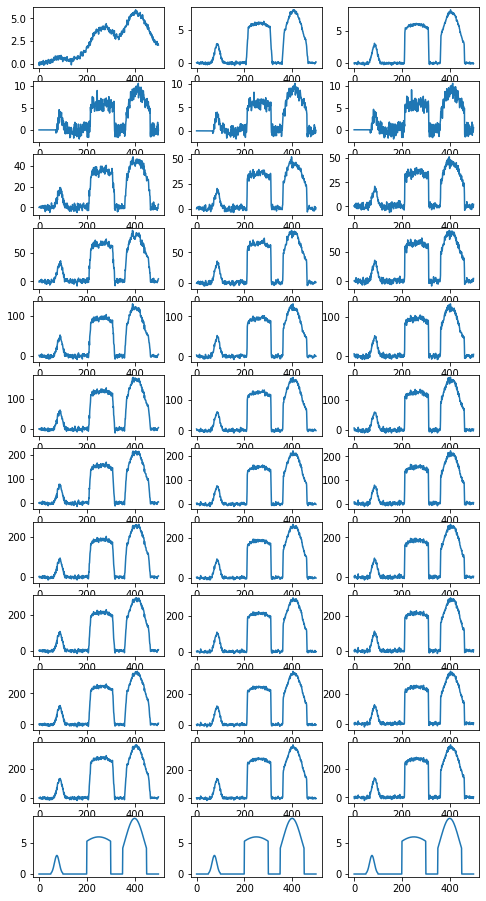

In [165]:
n_A_updates=3
fig, axes = plt.subplots(12, n_A_updates,figsize=(8,16))


for c in range(n_A_updates):
  

  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  pd.Series(A_prev).plot(ax=axes[0,c])

  # shift A
  A_shifted = np.zeros((shifts.shape[0],M))
  for shift_idx,shift in enumerate(shifts):
    A_shifted[shift_idx,:] = shift_zeropad(A_prev,shift)

  # norm A
  A_shifted_norm = np.linalg.norm(A_shifted,axis=1)**2

  # pdf shifts
  shift_pdf = np.zeros(shifts.shape)
  for idx,s in enumerate(shifts): 
    shift_pdf[idx] = np.exp(-s**2/(2*sigma_shift**2))*(2*np.pi)**-0.5#scipy.stats.norm.pdf(s,)#

  r=0
  best_shifts = np.zeros_like(true_shifts)

  idx_rand = np.arange(X.shape[0],dtype=np.int32)

  #np.random.shuffle(idx_rand)

  sigma2s = np.zeros(N)
  sigma_shift2s = np.zeros(N)
  for i,x in enumerate(X):

    # corr
    corr_A_x = compute_corr(A_shifted,x)
    best_shifts[i] = np.argmax(corr_A_x) - (N + 1)
    
    # gi
    A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
    corr_A_x_ = sigma**-2*corr_A_x
    Ki = np.max(corr_A_x_ + A_shifted_norm_) # for numerical stability?

    gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0

    # rev shift
    x_shifted = np.zeros((shifts.shape[0],X.shape[1]))
    for shift_idx,shift in enumerate(shifts):
      x_shifted[shift_idx,:] = shift_zeropad(x,-shift) # have to reverse shift?

    conv = np.zeros(A_prev.shape[0])
    for A_idx in range(A_prev.shape[0]):
    # sum over shifts
      conv[A_idx] = np.multiply(gi,x_shifted[:,A_idx]).sum()
      A_next[A_idx] += Ui*conv[A_idx] # perhaps accumulate and sum later... maybe better numerical stability
    
    if i % int(X.shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,A_next.max()))
      pd.Series(A_next).plot(ax=axes[r+1,c])
      r+=1

    # sigma estimation
    errors = np.linalg.norm(A_shifted - x,axis=1)**2 # difference between image and template. broadcast diff
    sigma2_i = (gi*errors).sum() / gi.sum()
    sigma2s[i] = sigma2_i

    # sigma shift estimation
    sigma_shift2s[i] = (gi*shifts**2).sum()/gi.sum()

  # update sigma
  print('old sigma % .2f' % sigma)
  sigma2 = sigma2s.sum()
  sigma2 /= N*M
  sigma = np.sqrt(sigma2)
  print('new sigma % .2f' % sigma)

  # update sigma shift
  print('old sigma shift % .2f' % sigma_shift)
  sigma_shift2 = sigma_shift2s.sum()
  sigma_shift2 /= N
  sigma_shift = np.sqrt(sigma_shift2)
  print('new sigma shift% .2f' % sigma_shift)

  A_next *= N**-1
  pd.Series(A).plot(ax=axes[r+1,c])

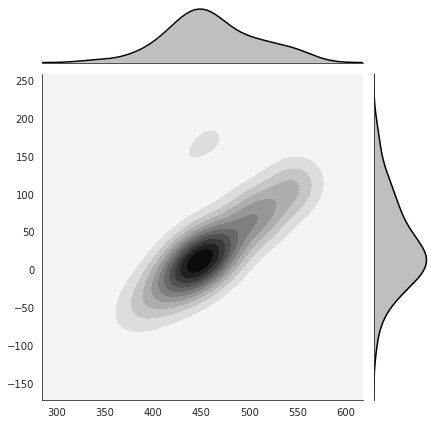

In [166]:
with sns.axes_style("white"):
    sns.jointplot(x=best_shifts, y=true_shifts, kind="kde", color="k");

# estimate mean shift from data
- if we minimize Eq. 12.10 wrt $\epsilon_q$, we get:
  * $\epsilon_q = N^{-1} \sum_i \frac{\int dq \ \gamma_i q}{\int dq^{'} \ \gamma_i^{'}}$
- it is not that critical to estiamte the mean shift, since the template is only accurate up to translations. even if the true shift is offset, in the final rounds the agreement between the (shifted) template and the images will bring the estimated mean shift to zero

## helper functions

In [0]:
shifts.shape,gi.shape


23221.38734705308

In [99]:
(gi*shifts).sum()# upstairs

-71.84274568362451

In [100]:
gi.sum() # downstairs

0.6269735570410226

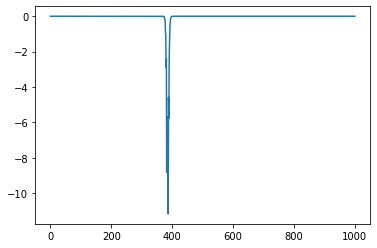

In [101]:
pd.Series(gi*shifts).plot() # makes intuitive sense... weights the shifts by gamma i

In [102]:
mean_shift = (gi*shifts).sum()/gi.sum()/N # real one is 100
mean_shift

-0.22917312820235533

## updated algorithm

array([-76,  20,  58, -10,  24,  17,  52,  73,  -2, -23, -43, -37, -71,
        43,  55, -31, -53, -16,  39, -66,  22, -47, -50,  73,  10, -16,
       -18,   6, -10, -47, -23,  87,   4, -14, 156,  42,  29,  36,  -4,
       -93, -75,  55,  -8, 120,   6,  64,   0,  -1,  55, -98], dtype=int32)

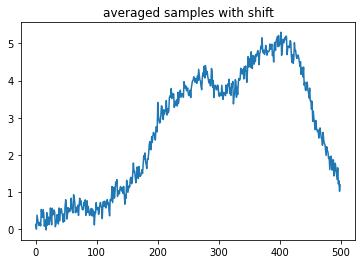

In [184]:
sigma_shift=50
mean_shift=10
X = np.zeros((N,M))
true_shifts = np.zeros(N,dtype=np.int32)
sigma=1
for i in range(N):
  X[i,:], true_shifts[i] = make_fake(A.copy(),sigma,sigma_shift=sigma_shift,mean_shift=mean_shift,return_shift=True)

pd.Series(X.mean(0)).plot(title='averaged samples with shift') 
true_shifts

In [0]:
A_prev = X.mean(0)
shifts = np.arange(-N,N+1, dtype=np.int32)
A_next = A_prev.copy()
sigma=sigma
sigma_shift = sigma_shift
mean_shift=0

i = 0, ll = -5504.63, A_next max = 10.58
i = 5, ll = -32070.28, A_next max = 54.73
i = 10, ll = -58635.36, A_next max = 98.32
i = 15, ll = -85884.65, A_next max = 143.69
i = 20, ll = -112724.32, A_next max = 188.42
i = 25, ll = -139229.81, A_next max = 233.32
i = 30, ll = -166720.23, A_next max = 278.67
i = 35, ll = -189999.30, A_next max = 318.97
i = 40, ll = -217257.87, A_next max = 360.59
i = 45, ll = -241579.02, A_next max = 395.67
old sigma  1.69
new sigma  2.49
old sigma shift  35.70
new sigma shift 36.68
old mean shift  0.00
new mean shift 2.08
i = 0, ll = -2527.84, A_next max = 10.59
i = 5, ll = -13888.24, A_next max = 55.59
i = 10, ll = -25363.47, A_next max = 99.26
i = 15, ll = -37137.84, A_next max = 145.72
i = 20, ll = -48663.31, A_next max = 190.03
i = 25, ll = -60083.24, A_next max = 234.76
i = 30, ll = -71767.09, A_next max = 281.97
i = 35, ll = -82033.28, A_next max = 320.86
i = 40, ll = -94178.71, A_next max = 363.22
i = 45, ll = -104804.61, A_next max = 403.80
old sig

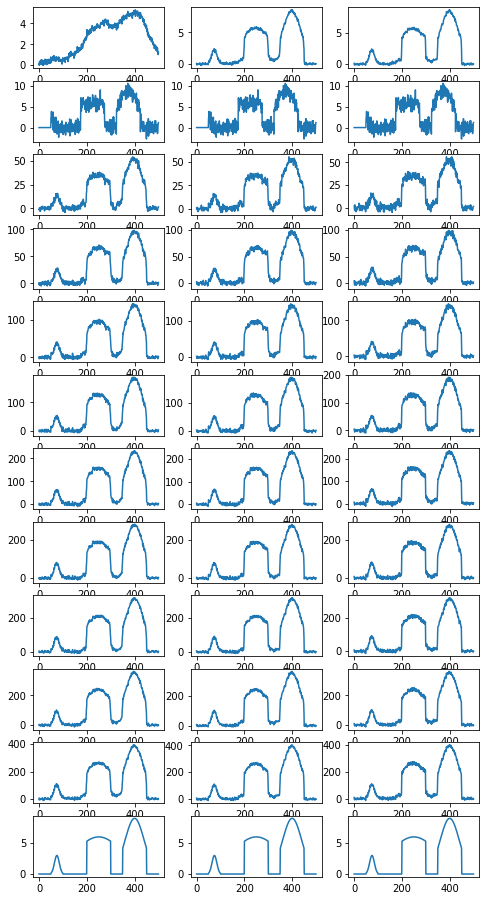

In [193]:
n_A_updates=3
fig, axes = plt.subplots(12, n_A_updates,figsize=(8,16))


for c in range(n_A_updates):
  

  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  pd.Series(A_prev).plot(ax=axes[0,c])

  # shift A
  A_shifted = np.zeros((shifts.shape[0],M))
  for shift_idx,shift in enumerate(shifts):
    A_shifted[shift_idx,:] = shift_zeropad(A_prev,shift)

  # norm A
  A_shifted_norm = np.linalg.norm(A_shifted,axis=1)**2

  # pdf shifts
  shift_pdf = np.zeros(shifts.shape)
  for idx,s in enumerate(shifts): 
    shift_pdf[idx] = np.exp(-(s-mean_shift)**2/(2*sigma_shift**2))*(2*np.pi)**-0.5#scipy.stats.norm.pdf(s,)#

  r=0
  best_shifts = np.zeros_like(true_shifts)

  idx_rand = np.arange(X.shape[0],dtype=np.int32)

  #np.random.shuffle(idx_rand)

  sigma2s = np.zeros(M)
  sigma_shift2s = np.zeros(M)
  mean_shifts = np.zeros(M)

  for i,x in enumerate(X):

    # corr
    corr_A_x = compute_corr(A_shifted,x)
    best_shifts[i] = np.argmax(corr_A_x) - (N + 1)
    
    # gi
    A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
    corr_A_x_ = sigma**-2*corr_A_x
    Ki = np.max(corr_A_x_ + A_shifted_norm_) # for numerical stability?

    gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0

    # rev shift
    x_shifted = np.zeros((shifts.shape[0],X.shape[1]))
    for shift_idx,shift in enumerate(shifts):
      x_shifted[shift_idx,:] = shift_zeropad(x,-shift) # have to reverse shift?

    conv = np.zeros(A_prev.shape[0])
    for A_idx in range(A_prev.shape[0]):
    # sum over shifts
      conv[A_idx] = np.multiply(gi,x_shifted[:,A_idx]).sum()
      A_next[A_idx] += Ui*conv[A_idx] # perhaps accumulate and sum later... maybe better numerical stability
    
    if i % int(X.shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,A_next.max()))
      pd.Series(A_next).plot(ax=axes[r+1,c])
      r+=1

    # sigma estimation
    errors = np.linalg.norm(A_shifted - x,axis=1)**2 # difference between image and template. broadcast diff
    sigma2_i = (gi*errors).sum() / gi.sum()
    sigma2s[i] = sigma2_i

    # sigma shift estimation
    sigma_shift2s[i] = (gi*shifts**2).sum()/gi.sum()

    mean_shifts[i] = (gi*shifts).sum()/gi.sum()


  # update sigma
  print('old sigma % .2f' % sigma)
  sigma2 = sigma2s.sum()
  sigma2 /= N*M
  sigma = np.sqrt(sigma2)
  print('new sigma % .2f' % sigma)

  # update sigma shift
  print('old sigma shift % .2f' % sigma_shift)
  sigma_shift2 = sigma_shift2s.sum()
  sigma_shift2 /= N
  sigma_shift = np.sqrt(sigma_shift2)
  print('new sigma shift% .2f' % sigma_shift)

  # update mean shift
  print('old mean shift % .2f' % mean_shift)
  mean_shift = mean_shifts.sum() / N
  print('new mean shift% .2f' % mean_shift)

  A_next *= N**-1
  pd.Series(A).plot(ax=axes[r+1,c])

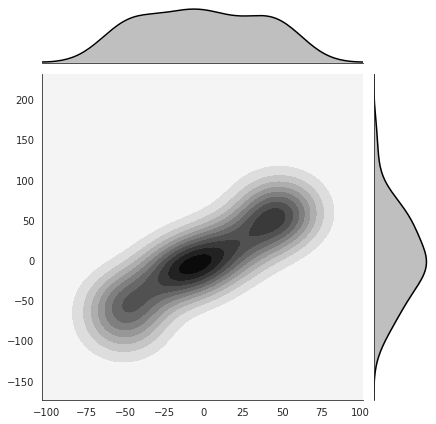

In [191]:
with sns.axes_style("white"):
    sns.jointplot(x=best_shifts, y=true_shifts, kind="kde", color="k"); # no estimate of mean shift

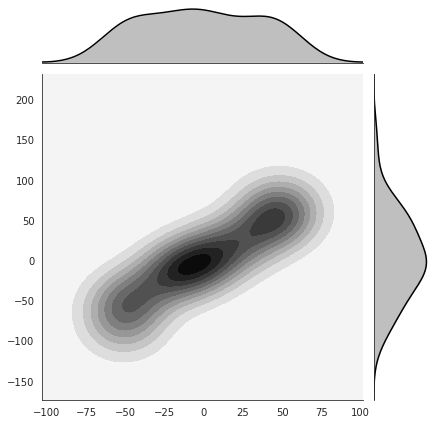

In [188]:
with sns.axes_style("white"):
    sns.jointplot(x=best_shifts, y=true_shifts, kind="kde", color="k"); # estimate of mean shift